In [1]:
import csv
import numpy as np
import tensorflow.keras as K
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd

2022-04-07 12:16:15.176216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 12:16:15.176231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class neural_net:
    def __init__(self, X, Y, topology, epochs=50, lr=0.0001, bs=4, early_tol=100, scale=False, 
                 earlystopping=False, dropout=False, do_val=0.5):
        
        self.topology = topology
        self.epochs = epochs
        self.lr = lr
        self.bs = bs
        self.early_tol = early_tol
        self.scale = scale
        self.earlystopping = earlystopping
        self.dropout = dropout
        self.do_val = do_val
        
        ntrain = int(0.8* len(X))
        indx = [ntrain]
        self.X_train, self.X_test = np.split(X, indx)
        self.Y_train, self.Y_test = np.split(Y, indx)
        
        if self.scale:
            self.scaler = StandardScaler()
            try:
                self.scaler.fit(X)
                self.X_train = self.scaler.transform(self.X_train)
                self.X_test = self.scaler.transform(self.X_test)
            except:
                self.scaler.fit(X.reshape(-1,1))
                self.X_train = self.scaler.transform(self.X_train.reshape(-1,1))
                self.X_test = self.scaler.transform(self.X_test.reshape(-1,1))

            self.X_train = self.scaler.transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)
        
        self.model = self.model()
        self.model.summary()
        
    def model(self):
        # Red neuronal
        model = K.models.Sequential()
        # Hidden layers

        for i, nodes in enumerate(self.topology):
            if i == 0:
                model.add(K.layers.Dense(self.topology[1], input_dim=self.topology[0], activation='relu'))
                if self.dropout:
                    model.add(K.layers.Dropout(self.do_val))
            elif i < len(self.topology)-2:
                model.add(K.layers.Dense(self.topology[i+1], activation='relu'))
                if self.dropout:
                    model.add(K.layers.Dropout(self.do_val))
            else:
                model.add(K.layers.Dense(self.topology[i], activation='linear'))
        optimizer = K.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        
        return model                    
    
    def train(self):
        callbacks = [K.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                               min_delta=0.01,
                                               patience=self.early_tol,
                                               restore_best_weights=True)]
        print("Entrenando, por favor, espera...")
        if self.earlystopping:
            self.history = self.model.fit(self.X_train,
                                          self.Y_train,
                                          validation_data=(self.X_test,
                                                           self.Y_test),
                                          epochs=self.epochs, batch_size=self.bs,
                                          callbacks=callbacks, verbose=0)
        else:
            self.history = self.model.fit(self.X_train,
                                          self.Y_train,
                                          validation_data=(self.X_test,
                                                           self.Y_test),
                                          epochs=self.epochs, batch_size=self.bs,
                                          verbose=0)
        print("¡Entrenamiento terminado!")
        return self.history
    
    def get_w_and_b(self, nlayer):
        weights, biases = self.model.layers[nlayer].get_weights()
        return weights, biases
    
    def predict(self, x):
        if type(x) == type([1]):
            x = np.array(x)
        if type(x) == type(1):
            x = np.array([x])
        if self.scale:
            try:
                x = self.scaler.transform(x)
            except:
                x = self.scaler.transform(x.reshape(-1,1))
        return self.model.predict(x)
        
    def plot(self):
        plt.plot(self.history.history['loss'], label='training set')
        plt.plot(self.history.history['val_loss'], label='validation set')
        mse = np.min(self.history.history['val_loss'])
        plt.title('MSE:{}'.format(mse))
        plt.ylabel('loss function')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        

In [3]:
data_iris = pd.read_csv('https://raw.githubusercontent.com/igomezv/DLCIMATAGS/main/data/iris/iris.data')
data_iris.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
data_iris["class"] = data_iris["class"].astype('category')
data_iris["class_num"] = data_iris["class"].cat.codes
data_iris

,sepallength,sepalwidth,petallength,petalwidth,class,class_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


### Iris-setosa-> 0, Iris-versicolor -> 1, Iris-virginica->2

In [5]:
X = data_iris[['sepallength', 'sepalwidth', 'petallength', 'petalwidth']]
Y = data_iris[['class_num']]
N = len(X)
X.head(), N

(   sepallength  sepalwidth  petallength  petalwidth
 0          5.1         3.5          1.4         0.2
 1          4.9         3.0          1.4         0.2
 2          4.7         3.2          1.3         0.2
 3          4.6         3.1          1.5         0.2
 4          5.0         3.6          1.4         0.2,
 150)

In [6]:
X = X.values
Y = Y.values

In [7]:
len(X), len(Y)

(150, 150)

In [8]:
v0 = int(len(X)*0.8)
x0 = X[:v0,:]
y0 = Y[:v0]
# y = y[:500]
# X = X[:500, :]
xtest = X[v0:, :]
ytest = Y[v0:]
np.shape(x0)

(120, 4)

## Modelo de red neuronal sin regularización

In [9]:
network = neural_net(x0, y0, topology=[4, 500, 500, 500, 1], epochs=500)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               2500      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total params: 754,501
Trainable params: 754,501
Non-trainable params: 0
_________________________________________________________________


2022-04-07 12:16:16.864355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-07 12:16:16.864371: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-07 12:16:16.864383: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isidro-pc): /proc/driver/nvidia/version does not exist
2022-04-07 12:16:16.864510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-04-07 12:16:16.927569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Entrenando, por favor, espera...
¡Entrenamiento terminado!


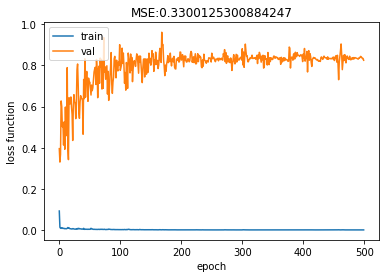

In [10]:
network.train()
network.plot()

## Con Early Stopping, paciencia=5 épocas

In [11]:
network_es = neural_net(x0, y0, topology=[4, 10, 10, 10, 1], epochs=500, early_tol=5, earlystopping=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________


Entrenando, por favor, espera...
¡Entrenamiento terminado!


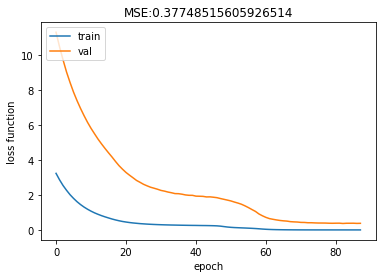

In [12]:
network_es.train()
network_es.plot()

## Con dropout = 0.5 en todas las capas

In [13]:
network_do = neural_net(x0, y0, topology=[4, 500, 500, 500, 1], epochs=1000, do_val=0.5, dropout=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               2500      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)              

Entrenando, por favor, espera...
¡Entrenamiento terminado!


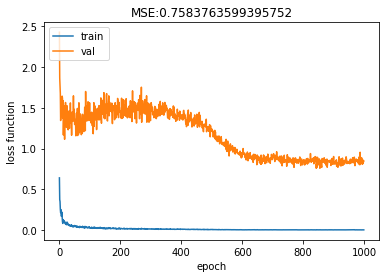

In [14]:
network_do.train()
network_do.plot()

## Con EarlyStopping y Dropout

In [28]:
network_esdo = neural_net(x0, y0, topology=[4, 500, 500, 500, 1], epochs=1000, do_val=0.5, dropout=True, early_tol=200, earlystopping=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 500)               2500      
_________________________________________________________________
dropout_21 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_22 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_23 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 500)              

Entrenando, por favor, espera...
¡Entrenamiento terminado!


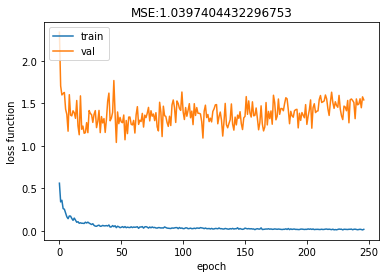

In [29]:
network_esdo.train()
network_esdo.plot()